In [1]:
# NumPy and odeint, our workhorses
import numpy as np
import scipy.integrate
import scipy
import scipy
import numba 
import pandas as pd
import time
# Plotting modules
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import bioscrape as bs
import bebi103
import corner
import emcee
import numba
import time
import pickle
from cycler import cycler

# Pretty plot settings from Anandh
mpl.font_manager._rebuild()
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

%config InlineBackend.figure_f.ormats=['svg']

# mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#mpl.rc('text', usetex=False)
#mpl.rc('text.latex', preamble=r'\usepackage{helvet}
#\renewcommand\familydefault{\sfdefault}\usepackage{sansmath}\sansmath')
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Roboto'], 
                 'serif': ['Roboto'],'weight':'normal'})

tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 14, 'axes.titlesize': 14,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(8.5,15))


# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [2]:
@numba.jit(nopython=True)
def naive_prod(concs, t, mu_P, mu_N, lam_MB, K, D, beta_p=1, V=1):
    """
    Function for solving ODEs for naive production.
    Returns np.array([dXP/dt (producers), dXN/dt (non-producers), dP/dt (protein/production)])
    concs: np.array([producer, non-producer, production])
    t: time array for ODE solver
    mu_P: specific growth rate of producers (1/h)
    mu_N: specific growth rate of non-producers (1/h)
    lam_MB: burden mutation rate (1/h)
    K: carrying capacity
    D: Dilution rate
    beta_P: protein production rate (proteins/h)
    V: Volume 
    """
    # total cell concentration
    ctot = concs[0:2].sum()
    
    # wild-type cells growth
    dXP_dt = mu_P*concs[0]*(K-ctot)/K - lam_MB*concs[0] - D*concs[0]
    
    # mutant cells growth
    dXN_dt = lam_MB*concs[0] + mu_N*concs[1]*(K-ctot)/K - D*concs[1]
    
    # Production rate of product
    dP_dt = beta_p*concs[0]*(K-ctot)/K*V
    
    return np.array([dXP_dt, dXN_dt, dP_dt])

def naive_prod_platereader(t, c0, mu_P, mu_N, lam_MB, K, D, beta_p=1, V=1, dilution_factor=50,
                           frac_at_dilution=0.95,frac_producers=0.1):
    """
    Returns number of dilutions in which the ending fraction of producers is > frac_producers.
    Allows modeling of repeated dilutions of specified dilution factor in batch culture. 
    Output from ODE solver for each dilution will be trimmed to the time when total population > K*frac_at_dilution.
    Simulation will be terminated when fraction of producers is < frac_producers
    
    dilution_factor: cell concentrations will be divided by this number after each batch growth
    frac_at_dilution: fraction of carrying carrying capacity at which to re-dilute.
    """   
    concs = c0
    production = 0
    dilute_again = True
    dilution_num = 0
    
    while dilute_again:
        out = scipy.integrate.odeint(naive_prod, concs, t, 
                                 args=(mu_P, mu_N, lam_MB, K, 0, beta_p, V))
        pop_tots = out[0:-1].sum(axis=1)
        
        if pop_tots[-1] < frac_at_dilution*K:
            end_loc = -1
        else:
            end_loc = np.argwhere(pop_tots>frac_at_dilution*K).min()
        
        end_concs = out[end_loc]
        
        # Terminate simulation if insufficient producers
        if end_concs[0] / end_concs[0:-1].sum() < frac_producers:
            dilute_again = False
        else:
            concs = end_concs / dilution_factor
            concs[-1] = 0
            dilution_num += 1
            
    return dilution_num

In [3]:
@numba.jit(nopython=True)
def diff_prod(concs, t, mu_P, mu_N, mu_M, lam_diff, lam_MB, lam_MD, K, D, beta_p, V):
    """
    Function for solving ODEs for production with differentiation.
    Returns np.array([dXPP/dt (progenitors), dXM/dt (non-producer mutants), dXDP/dt (differentiated producers), dP/dt (protein/production)])
    concs: np.array([producer, non-producer, production])
    t: time array for ODE solver
    mu_P: specific growth rate of producers (1/h)
    mu_N: specific growth rate of progenitor cells/non-producers (1/h)
    mu_M: specific growth rate of mutant non-producers
    lam_diff: differentiation rate (1/h)
    lam_MB: burden mutation rate (1/h)
    lam_MD: differentiation mutation rate (1/h)
    K: carrying capacity
    D: Dilution rate
    beta_P: protein production rate (proteins/(cell*h))
    V: Volume 
    """
    
    # Do not allow any negative concentrations
    concs[concs<0] = 0
    
    # allocate empty array for ddts
    ddts = np.zeros(len(concs))
    
    # total cell population
    ctot = concs[0:3].sum()
    
    ddts[0] = mu_N*concs[0]*(K-ctot)/K - lam_diff*concs[0] - (lam_MB+lam_MD)*concs[0]- D*concs[0]
    
    ddts[1] = mu_M*concs[1]*(K-ctot)/K + (lam_MB+lam_MD)*concs[0] +  lam_MB*concs[2] - D*concs[1]
    
    ddts[2] = mu_P*concs[2]*(K-ctot)/K + lam_diff*concs[0] - lam_MB*concs[2] - D*concs[2]
    
    ddts[3] = beta_p*concs[2]*(K-ctot)/K*V
        
    return ddts

def diff_prod_platereader_lhood(t, c0, mu_P, mu_N, mu_M, lam_diff, lam_MB, lam_MD, K, beta_p=1, 
                                V=1, dilution_factor=50,frac_at_dilution=0.95,frac_producers=0.1):
    """
    Returns number of dilutions for differentiation architecture in which the ending fraction of producers 
    is > frac_producers. Allows modeling of repeated dilutions of specified dilution factor in batch culture. 
    Output from ODE solver for each dilution will be trimmed to the time when total population > K*frac_at_dilution.
    Simulation will be terminated when fraction of producers is < frac_producers
    
    dilution_factor: cell concentrations will be divided by this number after each batch growth
    frac_at_dilution: fraction of carrying carrying capacity at which to re-dilute.
    """
    production = 0
    dilute_again = True
    dilution_num = 0
    concs=c0
    
    while dilute_again:
        out = scipy.integrate.odeint(diff_prod, concs, t, 
                                     args=(mu_P, mu_N, mu_M, lam_diff, lam_MB, lam_MD, K, 0, beta_p, V))
        
        pop_tots = out[0:-1].sum(axis=1)
        
        if pop_tots[-1] < frac_at_dilution*K:
            end_loc = -1
        else:
            end_loc = np.argwhere(pop_tots>frac_at_dilution*K).min()
        
        end_concs = out[end_loc]
        if end_concs[2] / end_concs[0:-1].sum() < frac_producers:
            dilute_again = False
            
        else:
            concs = end_concs / dilution_factor
            concs[-1] = 0
            dilution_num += 1
            
    return dilution_num


def diff_prod_platereader_post(par, t, c0, mu_P, mu_N, mu_M, lam_MB, lam_MD, K, beta_p, 
              V, dilution_factor=50,frac_at_dilution=0.95,frac_producers=0.1):
    """
    Checks parameter values, returns number of dilutions.
    par: lam_diff (differentiation rate) should be log(differentiation rate)
    """
    lam_diff, = np.exp(par)
    
    if lam_diff>600:
        return 0
        
    
    # Outgrow to get concentrations
    post_out = diff_prod_platereader_lhood(t, c0, mu_P, mu_N, mu_M, lam_diff, lam_MB, lam_MD, K, 
                                           beta_p, V, dilution_factor, frac_at_dilution,frac_producers)
    
    return post_out

def neg_diff_post(par, t, c0, mu_P, mu_N, mu_M, lam_MB, lam_MD, K, beta_p, 
              V, dilution_factor=50,frac_at_dilution=0.95,frac_producers=0.1):
    """
    Returns negative production for optimization/mcmc
    """
    return -diff_prod_platereader_post(par, t, c0, mu_P, mu_N, mu_M, lam_MB, lam_MD, K, beta_p, 
              V, dilution_factor,frac_at_dilution,frac_producers)

In [4]:
@numba.jit(nopython=True)
def diff_select_prod(concs, t, mu_PP, mu_PN, mu_MP, mu_MN, mu_DPs, mu_DNs, lam_diff, lam_MB, lam_MD, 
                        lam_MS, K, n_div, D, nodiv_prod=False, nodiv_ctot_count=False, beta_p=1, V=1):
    """
    Function for solving ODEs for production with terminal differentiation.
    Returns array of d/dts for cell concentrations and production
    Array is in the order: PP, PN, MP, MN, DP(0)...DP(n), DN(0)..DN(n), p
        PP: progenitor producer (progenitor cell that will differentiate into a differentiated producer)
        PN: progenitor non-producer
        MP: Mutant producer (producer that will divide indefinitely)
        MN: Mutant non-producer (non-producer that will divide indefiniteley and not differentiate)
        DP(0)...DP(n): Differentiated producers with n-i divisions remaining
        DN(0)...DN(n): Differentiated non-producers with n-i divisions remaining      
        p: product/protein
    t: time array for ODE solver
    mu_P: specific growth rate of producers (1/h)
    mu_N: specific growth rate of progenitor cells/non-producers (1/h)
    mu_M: specific growth rate of mutant non-producers
    lam_diff: differentiation rate (1/h)
    lam_MB: burden mutation rate (1/h)
    lam_MD: differentiation mutation rate (1/h)
    lam_MS: selection mutation rate (1/h)
    K: carrying capacity
    n_div: number of divisions differentiated cells can undergo
    D: Dilution rate
    nodiv_prod: If True, differentiated cells with 0 divisions remaining will produce product/protein
    nodiv_ctot_count: If True, differentiated cells with 0 divisions remaining will count towards total cell count
    beta_P: protein production rate (proteins/(cell*h))
    V: Volume 
    """
    
    # allocate empty array for ddts
    ddts = np.zeros(len(concs))
    
    # total cell population
    if nodiv_ctot_count:
        ctot = concs[0:-1].sum()
    else:
        ctot = concs[0:-1].sum() - concs[4+n_div] - concs[5+2*n_div]
    
    # stem cell producers
    ddts[0] = mu_PP*concs[0]*(K-ctot)/K - (lam_diff+lam_MB+lam_MD)*concs[0] - D*concs[0]
    
    # stem cell non-producers
    ddts[1] = mu_PN*concs[1]*(K-ctot)/K + lam_MB*concs[0] - (lam_diff+lam_MD)*concs[1] - D*concs[1]
    
    # mutant producers
    ddts[2] = mu_MP*concs[2]*(K-ctot)/K + lam_MS*np.sum(concs[4:4+n_div]) - lam_MB*concs[2] - D*concs[2]
    
    # mutant non-producers
    ddts[3] = mu_MN*concs[3]*(K-ctot)/K + lam_MD*(concs[0]+concs[1]) + lam_MB*concs[2] \
                + lam_MS*(np.sum(concs[5+n_div:5+2*n_div])) - D*concs[2]
    
    # Differentiated producers with n remaining divisions
    ddts[4] = lam_diff*concs[0] - mu_DPs[0]*concs[4]*(K-ctot)/K - (lam_MB+lam_MS)*concs[4] - D*concs[4]
    
    # Differentiated non-producers with n remaining divisions
    ddts[5+n_div] = lam_diff*concs[1] - mu_DNs[0]*(K-ctot)/K*concs[5+n_div] + lam_MB*concs[4] \
                    - lam_MS*concs[5+n_div] - D*concs[5+n_div]
    
    # Differentiated producers and non-producers with <n remaining cell divisions
    for i in range(n_div):
        if i < (n_div-1):
            ddts[i+5] = (2*mu_DPs[i]*(concs[i+4]) - mu_DPs[i+1]*concs[i+5])*(K-ctot)/K \
                            - (lam_MB+lam_MS)*concs[i+5] - D*concs[i+5]
            ddts[i+6+n_div] = (2*mu_DNs[i]*(concs[i+5+n_div]) - mu_DNs[i+1]*concs[i+6+n_div])*(K-ctot)/K \
                                + lam_MB*concs[i+5] - lam_MS*concs[i+6+n_div] - D*concs[i+6+n_div]
        # Differentiated cells with no remaining cell divisions
        else:
            ddts[i+5] = 2*mu_DPs[i]*concs[i+4]*(K-ctot)/K - D*concs[i+5]
            ddts[i+6+n_div] = 2*mu_DNs[i]*(concs[i+5+n_div])*(K-ctot)/K - D*concs[i+6+n_div]
    
    #Production
    ddts[-1] = (beta_p*(concs[4:4+n_div+nodiv_prod].sum() + concs[2]))*(K-ctot)/K*V

    return ddts

def diff_select_prod_platereader_lhood(t, c0, mu_PP, mu_PN, mu_MP, mu_MN, mu_DPs, mu_DNs, 
                                          lam_diff, lam_MB, lam_MD, lam_MS, K, n_div, 
                                          nodiv_prod=False, nodiv_ctot_count=False, beta_p=1, 
                                          V=1, dilution_factor=50,frac_at_dilution=0.95,frac_producers=0.1):
    """
    Returns number of dilutions for terminal differentiation architecture in which the ending fraction of producers 
    is > frac_producers. Allows modeling of repeated dilutions of specified dilution factor in batch culture. 
    Output from ODE solver for each dilution will be trimmed to the time when total population > K*frac_at_dilution.
    Simulation will be terminated when the production for an individual batch growth < 1000.
    
    dilution_factor: cell concentrations will be divided by this number after each batch growth
    frac_at_dilution: fraction of carrying carrying capacity at which to re-dilute.
    """   
    production = 0
    dilute_again = True
    concs = c0
    dilution_num = 0
    
    while dilute_again:
        out = scipy.integrate.odeint(diff_select_prod, concs, t, 
                                      args=(mu_PP, mu_PN, mu_MP, mu_MN, mu_DPs, mu_DNs, lam_diff, lam_MB, lam_MD, 
                                            lam_MS, K, n_div, 0, nodiv_prod, nodiv_ctot_count, beta_p, V))
        pop_tots = out[0:-1].sum(axis=1)
        
        if pop_tots[-1] < frac_at_dilution*K:
            end_loc = -1
        else:
            end_loc = np.argwhere(pop_tots>frac_at_dilution*K).min()
        
        end_concs = out[end_loc]
        if (end_concs[2] +  end_concs[4:5+n_div].sum()) / end_concs[0:-1].sum() < frac_producers:
            dilute_again = False
            
        else:
#             production += end_concs[-1]
            concs = end_concs / dilution_factor
            concs[-1] = 0
            dilution_num += 1
            
    return dilution_num

def diff_select_prod_platereader_post(par, t, c0, mu_PP, mu_PN, mu_MP, mu_MN, mu_DPs, mu_DNs, 
                                          lam_MB, lam_MD, lam_MS, K, n_div, 
                                          nodiv_prod=False, nodiv_ctot_count=False, beta_p=1, 
                                          V=1, dilution_factor=50,frac_at_dilution=0.95,frac_producers=0.1):
    """
    Checks parameter values, returns number of dilutions.
    par: lam_diff (differentiation rate) should be log(differentiation rate)
    """
    lam_diff, = np.exp(par)
    
    if lam_diff>600:
        return 0
        
    
    # Outgrow to get concentrations
    post_out = diff_select_prod_platereader_lhood(t, c0, mu_PP, mu_PN, mu_MP, mu_MN, mu_DPs, mu_DNs, 
                                          lam_diff, lam_MB, lam_MD, lam_MS, K, n_div, 
                                          nodiv_prod, nodiv_ctot_count, beta_p, V, dilution_factor,
                                          frac_at_dilution,frac_producers)
        
    return post_out

def neg_diff_select_post(par, t, c0, mu_PP, mu_PN, mu_MP, mu_MN, mu_DPs, mu_DNs, 
                                          lam_MB, lam_MD, lam_MS, K, n_div, 
                                          nodiv_prod=False, nodiv_ctot_count=False, beta_p=1, 
                                          V=1, dilution_factor=50,frac_at_dilution=0.95,frac_producers=0.1):
    """
    Returns negative production for optimization/mcmc
    par: lam_diff (differentiation rate) should be log(differentiation rate)
    """
    
    return -diff_select_prod_platereader_post(par, t, c0, mu_PP, mu_PN, mu_MP, mu_MN, mu_DPs, mu_DNs, 
                                          lam_MB, lam_MD, lam_MS, K, n_div, nodiv_prod, nodiv_ctot_count, 
                                          beta_p, V, dilution_factor, frac_at_dilution,frac_producers)

We will now run the simulations for naive, differentiation, and terminal differentiation with 4 divisions allowed for differentiated cells in the terminal differentiation case.

In [5]:
# Create data frames to store outputs of simulations
df_naive_duration_plate = pd.DataFrame(columns=['method','mu_P', 'mu_N','lam_MB','n_dilutions'])

naive_cols = df_naive_duration_plate.columns

df_MAP_params_d_plate = pd.DataFrame(columns=['method','mu_P', 'mu_N', 'mu_M', 'lam_MB', 'lam_MD',
                                    'lam_diff','n_dilutions'])
d_param_cols = df_MAP_params_d_plate.columns

df_MAP_params_ds_plate = pd.DataFrame(columns=['method','mu_PP', 'mu_PN', 'mu_MP', 'mu_MN', 'mu_DPs', 
                                    'mu_DNs', 'lam_MB', 'lam_MD', 'lam_MS', 'n_div','lam_diff'
                                    'n_dilutions'])
ds_param_cols = df_MAP_params_ds_plate.columns

In [6]:
# Parameter values and starting conditions
n_div=4
burdens = np.array([0.1,0.5,0.9])
burdens = np.round(burdens,1)
lam_MDs = np.array([1e-3,1e-6,1e-9,1e-12])
lam_MBs = lam_MDs
lam_MSs = np.array([1e-3,1e-6,1e-9,1e-12,0])
t = np.linspace(0,12,1200)
mu_N = 1.5
mu_M = mu_N
mu_PP = mu_N
mu_PN = mu_N
mu_MN = mu_N
mu_DNs = np.ones(n_div+1)*mu_N
dilution_factor=50
K = 1e9
nodiv_prod=False
nodiv_ctot_count=False
production_constant = True
beta_p=1
V=1
X_PP0=1e6
X_PN0=0
X_MP0=0
X_MN0=0
start_p0 = np.array([0.001,0.1,1]) # Three different staring lam_diff values for optimization
frac_at_dilution = 0.95
frac_producers = 0.1

# Either load data or re-run simulations, it will take a couple hours or so to run all burdens/mutation rates
try:
    df_naive_duration_plate = pd.read_csv('./naive_duration.csv')
    df_MAP_params_d_plate = pd.read_csv('./diff_duration_lamdiff_optimization.csv')
    df_MAP_params_ds_plate = pd.read_csv('./terminal_diff_duration_lamdiff_optimization_4div.csv')
    
except:  
    for i, burden in enumerate(burdens):
        print('starting loop for burden = ' + str(burden))
        for j, lam_MB in enumerate(lam_MBs):
            print('starting loop for lam_MB =' + str(lam_MB))
            # Run simulation for naive n_dilutions
            concs = np.array([X_PP0, 0, 0])
            mu_P = mu_N*(1-burden)
            naive_prod_output = naive_prod_platereader(t, concs, mu_P, mu_N, lam_MB, K, 0,beta_p=beta_p,V=V,
                                            dilution_factor=dilution_factor,frac_at_dilution=frac_at_dilution,
                                            frac_producers=frac_producers)

            # Append results to dataframe
            naive_append = pd.DataFrame(columns=naive_cols,data=np.zeros((1,len(naive_cols))))
            naive_append['method'] = 'naive'
            naive_append['mu_P'] = mu_P
            naive_append['mu_N'] = mu_N
            naive_append['lam_MB'] = lam_MB
            naive_append['n_dilutions'] = naive_prod_output
            df_naive_output_plate = df_naive_output_plate.append(naive_append)

            for k, lam_MD in enumerate(lam_MDs):
                print('starting loop for lam_MD =' + str(lam_MD))
                # Run optimization for differentiation
                c0 = np.array([X_PP0,0,0,0]) 
                args = (t, c0, mu_P, mu_N, mu_M, lam_MB, lam_MD, K, beta_p, V, dilution_factor,frac_at_dilution,
                       frac_producers)
                popt = np.zeros(len(start_p0))
                prod = np.zeros(len(start_p0))
                for ii, lam_diff_start in enumerate(start_p0):
                    params_0 = np.array([np.log(lam_diff_start)])

                    res = scipy.optimize.minimize(neg_diff_post, 
                                                  params_0,
                                                  args=args,
                                                  method='powell')
                    popt[ii] = np.exp(res.x)
                    prod[ii] = -res.fun
                max_loc = prod.argmax()
                # Append results to diff dataframe
                diff_append = (pd.DataFrame(columns=d_param_cols,data=np.zeros((1,len(d_param_cols)))))
                diff_append['method'] = 'diff'
                diff_append['mu_P'] = mu_P
                diff_append['mu_N'] = mu_N
                diff_append['mu_M'] = mu_M
                diff_append['n_dilutions'] = prod[max_loc]
                diff_append['lam_MB'] = lam_MB
                diff_append['lam_MD'] = lam_MD
                diff_append['lam_diff'] = popt[max_loc]
                df_MAP_params_d_plate = df_MAP_params_d_plate.append(diff_append)

                # Run optimization for terminal differentiation for each selection mutation rate
                for l, lam_MS in enumerate(lam_MSs):
                    mu_DPs = np.ones(n_div+1)*mu_N*(1-burden)
                    mu_DPs[-1] = 0
                    mu_DNs = np.ones(n_div+1)*mu_N
                    mu_DNs[-1] = 0
                    mu_MP = mu_N*(1-burden)
                    mu_MN = mu_N
                    c0 = np.concatenate((np.array([X_PP0,X_PN0,X_MP0,X_MN0]),np.zeros(2*n_div+3)))
                    args = (t, c0, mu_PP, mu_PN, mu_MP, mu_MN, mu_DPs, mu_DNs, lam_MB, lam_MD, lam_MS, 
                            K, n_div, nodiv_prod, nodiv_ctot_count, beta_p, V, dilution_factor,frac_at_dilution)
                    popt = np.zeros(len(start_p0))
                    prod = np.zeros(len(start_p0))
                    for ii, lam_diff_start in enumerate(start_p0):
                        params_0 = np.array([np.log(lam_diff_start)])
                        res = scipy.optimize.minimize(neg_diff_select_post, 
                                                      params_0,
                                                      args=args,
                                                      method='powell')
                        popt[ii] = np.exp(res.x)
                        prod[ii] = -res.fun
                    max_loc = prod.argmax()


                    # Append results to terminal differentiation dataframe
                    diff_select_append = (pd.DataFrame(columns=ds_param_cols,data=np.zeros((1,len(ds_param_cols)))))
                    diff_select_append['method'] = 'diff_select'
                    diff_select_append['mu_PP'] = mu_PP
                    diff_select_append['mu_PN'] = mu_PN
                    diff_select_append['mu_MP'] = mu_MP
                    diff_select_append['mu_MN'] = mu_MN
                    diff_select_append['mu_DNs'] = mu_DNs[0]
                    diff_select_append['mu_DPs'] = mu_DPs[0]
                    diff_select_append['lam_MB'] = lam_MB
                    diff_select_append['lam_MD'] = lam_MD
                    diff_select_append['lam_MS'] = lam_MS
                    diff_select_append['n_div'] = n_div
                    diff_select_append['lam_diff'] = popt[max_loc]
                    diff_select_append['n_dilutions'] = prod[max_loc]
                    df_MAP_params_ds_plate = df_MAP_params_ds_plate.append(diff_select_append)

In [7]:
df_naive_duration_plate.to_csv('./naive_duration.csv')
df_MAP_params_d_plate.to_csv('./diff_duration_lamdiff_optimization.csv')
df_MAP_params_ds_plate.to_csv('./terminal_diff_duration_lamdiff_optimization_4div.csv')

We will now do the same thing as above for terminal differentiation, but with 8 divisions allowed for differentiated cells.

In [8]:
df_MAP_params_ds_plate = pd.DataFrame(columns=['method','mu_PP', 'mu_PN', 'mu_MP', 'mu_MN', 'mu_DPs', 
                                    'mu_DNs', 'lam_MB', 'lam_MD', 'lam_MS', 'n_div','lam_diff'
                                    'n_dilutions'])

ds_param_cols = df_MAP_params_ds_plate.columns

In [9]:
# Parameter values and starting conditions
n_div=8
burdens = np.array([0.1,0.5,0.9])
burdens = np.round(burdens,1)
lam_MDs = np.array([1e-3,1e-6,1e-9,1e-12])
lam_MBs = lam_MDs
lam_MSs = np.array([1e-3,1e-6,1e-9,1e-12,0])
t = np.linspace(0,12,1200)
mu_N = 1.5
mu_M = mu_N
mu_PP = mu_N
mu_PN = mu_N
mu_MN = mu_N
mu_DNs = np.ones(n_div+1)*mu_N
dilution_factor=50
K = 1e9
nodiv_prod=False
nodiv_ctot_count=False
production_constant = True
beta_p=1
V=1
X_PP0=1e6
X_PN0=0
X_MP0=0
X_MN0=0
start_p0 = np.array([0.001,0.1,1]) # Three different staring lam_diff values for optimization
frac_at_dilution = 0.95
frac_producers = 0.1

# Either load csv or re-run simulations
try:
    df_MAP_params_ds_plate = pd.read_csv('./terminal_diff_duration_lamdiff_optimization_8div.csv')
except:   
    for i, burden in enumerate(burdens):
        print('starting loop for burden = ' + str(burden))
        for j, lam_MB in enumerate(lam_MBs):
            print('starting loop for lam_MB =' + str(lam_MB))
            for k, lam_MD in enumerate(lam_MDs):
                # Run optimization for terminal differentiation for each selection mutation rate
                for l, lam_MS in enumerate(lam_MSs):
                    mu_DPs = np.ones(n_div+1)*mu_N*(1-burden)
                    mu_DPs[-1] = 0
                    mu_DNs = np.ones(n_div+1)*mu_N
                    mu_DNs[-1] = 0
                    mu_MP = mu_N*(1-burden)
                    mu_MN = mu_N
                    c0 = np.concatenate((np.array([X_PP0,X_PN0,X_MP0,X_MN0]),np.zeros(2*n_div+3)))
                    args = (t, c0, mu_PP, mu_PN, mu_MP, mu_MN, mu_DPs, mu_DNs, lam_MB, lam_MD, lam_MS, 
                            K, n_div, nodiv_prod, nodiv_ctot_count, beta_p, V, dilution_factor,frac_at_dilution)
                    popt = np.zeros(len(start_p0))
                    prod = np.zeros(len(start_p0))
                    for ii, lam_diff_start in enumerate(start_p0):
                        params_0 = np.array([np.log(lam_diff_start)])
                        res = scipy.optimize.minimize(neg_diff_select_post, 
                                                      params_0,
                                                      args=args,
                                                      method='powell')
                        popt[ii] = np.exp(res.x)
                        prod[ii] = -res.fun
                    max_loc = prod.argmax()


                    # Append results to terminal differentiation dataframe
                    diff_select_append = (pd.DataFrame(columns=ds_param_cols,data=np.zeros((1,len(ds_param_cols)))))
                    diff_select_append['method'] = 'diff_select'
                    diff_select_append['mu_PP'] = mu_PP
                    diff_select_append['mu_PN'] = mu_PN
                    diff_select_append['mu_MP'] = mu_MP
                    diff_select_append['mu_MN'] = mu_MN
                    diff_select_append['mu_DNs'] = mu_DNs[0]
                    diff_select_append['mu_DPs'] = mu_DPs[0]
                    diff_select_append['lam_MB'] = lam_MB
                    diff_select_append['lam_MD'] = lam_MD
                    diff_select_append['lam_MS'] = lam_MS
                    diff_select_append['n_div'] = n_div
                    diff_select_append['lam_diff'] = popt[max_loc]
                    diff_select_append['n_dilutions'] = prod[max_loc]
                    df_MAP_params_ds_plate = df_MAP_params_ds_plate.append(diff_select_append)

In [10]:
df_MAP_params_ds_plate.to_csv('./terminal_diff_duration_lamdiff_optimization_8div.csv')

In [11]:
# Load data
df_naive_duration_plate = pd.read_csv('./naive_duration.csv')
df_MAP_params_d_plate = pd.read_csv('./diff_duration_lamdiff_optimization.csv')
df_MAP_params_ds_plate_4div = pd.read_csv('./terminal_diff_duration_lamdiff_optimization_4div.csv')
df_MAP_params_ds_plate_8div = pd.read_csv('./terminal_diff_duration_lamdiff_optimization_8div.csv')

# Avoid rounding errors
df_naive_duration_plate['mu_P'] = np.round(df_naive_duration_plate['mu_P'].values,2)
df_MAP_params_d_plate['mu_P'] = np.round(df_MAP_params_d_plate['mu_P'].values,2)
df_MAP_params_ds_plate_4div['mu_DPs'] = np.round(df_MAP_params_ds_plate_4div['mu_DPs'].values,2)
df_MAP_params_ds_plate_8div['mu_DPs'] = np.round(df_MAP_params_ds_plate_8div['mu_DPs'].values,2)

df_naive_duration_plate = df_naive_duration_plate.drop_duplicates()
df_MAP_params_d_plate = df_MAP_params_d_plate.drop_duplicates()
df_MAP_params_ds_plate_4div = df_MAP_params_ds_plate_4div.drop_duplicates()
df_MAP_params_ds_plate_8div = df_MAP_params_ds_plate_8div.drop_duplicates()


In [12]:
print(df_naive_duration_plate.mu_P.unique())
print(df_MAP_params_d_plate.mu_P.unique())
print(df_MAP_params_ds_plate_4div.mu_DPs.unique())
print(df_MAP_params_ds_plate_8div.mu_DPs.unique())

[1.35 0.75 0.15]
[1.35 0.75 0.15]
[1.35 0.75 0.15]
[1.35 0.75 0.15]


In [13]:
mu_Ps = df_naive_duration_plate.mu_P.unique()
mu_Ps = np.sort(mu_Ps)
lam_MBs = df_naive_duration_plate.lam_MB.unique()
lam_MBs = np.sort(lam_MBs)
lam_MDs = df_MAP_params_d_plate.lam_MD.unique()
lam_MDs = np.sort(lam_MDs)
lam_MSs = df_MAP_params_ds_plate_4div.lam_MS.unique()
lam_MSs = np.sort(lam_MSs)
print(mu_Ps)
print(lam_MBs)
print(lam_MDs)
print(lam_MSs)

[0.15 0.75 1.35]
[1.e-12 1.e-09 1.e-06 1.e-03]
[1.e-12 1.e-09 1.e-06 1.e-03]
[0.e+00 1.e-12 1.e-09 1.e-06 1.e-03]


In [14]:
df_naive_duration_plate.head()

,Unnamed: 0,Unnamed: 0.1,method,mu_P,mu_N,lam_MB,n_dilutions
0,0,0,naive,1.35,1.5,1.000000e-12,63
1,1,0,naive,1.35,1.5,1.000000e-09,47
2,2,0,naive,1.35,1.5,1.000000e-06,32
3,3,0,naive,1.35,1.5,1.000000e-03,16
4,4,0,naive,0.75,1.5,1.000000e-12,7


In [15]:
# Add column with n_dilutions normalized to naive duration
df_MAP_params_d_plate['norm_duration'] = 0
df_MAP_params_ds_plate_4div['norm_duration'] = 0
df_MAP_params_ds_plate_8div['norm_duration'] = 0
for i, mu_P in enumerate(mu_Ps):
    for j, lam_MB in enumerate(lam_MBs):
        df_MAP_params_d_plate.loc[(df_MAP_params_d_plate.mu_P==mu_P) & (df_MAP_params_d_plate.lam_MB==lam_MB),
                                  'norm_duration'] = \
            df_MAP_params_d_plate.loc[(df_MAP_params_d_plate.mu_P==mu_P) & (df_MAP_params_d_plate.lam_MB==lam_MB),
                                  'n_dilutions'] / \
            df_naive_duration_plate.loc[(df_naive_duration_plate.mu_P==mu_P) & (df_naive_duration_plate.lam_MB==lam_MB),
                                  'n_dilutions'].values
        df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_P) & (df_MAP_params_ds_plate_4div.lam_MB==lam_MB),
                                  'norm_duration'] = \
            df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_P) & (df_MAP_params_ds_plate_4div.lam_MB==lam_MB),
                                  'n_dilutions'] / \
            df_naive_duration_plate.loc[(df_naive_duration_plate.mu_P==mu_P) & (df_naive_duration_plate.lam_MB==lam_MB),
                                  'n_dilutions'].values
        df_MAP_params_ds_plate_8div.loc[(df_MAP_params_ds_plate_8div.mu_DPs==mu_P) & (df_MAP_params_ds_plate_8div.lam_MB==lam_MB),
                                  'norm_duration'] = \
            df_MAP_params_ds_plate_8div.loc[(df_MAP_params_ds_plate_8div.mu_DPs==mu_P) & (df_MAP_params_ds_plate_8div.lam_MB==lam_MB),
                                  'n_dilutions'] / \
            df_naive_duration_plate.loc[(df_naive_duration_plate.mu_P==mu_P) & (df_naive_duration_plate.lam_MB==lam_MB),
                                  'n_dilutions'].values
df_MAP_params_d_plate['log2_norm'] = np.log2(df_MAP_params_d_plate['norm_duration'])
df_MAP_params_ds_plate_4div['log2_norm'] = np.log2(df_MAP_params_ds_plate_4div['norm_duration'])
df_MAP_params_ds_plate_8div['log2_norm'] = np.log2(df_MAP_params_ds_plate_8div['norm_duration'])

/Users/rorywilliams/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


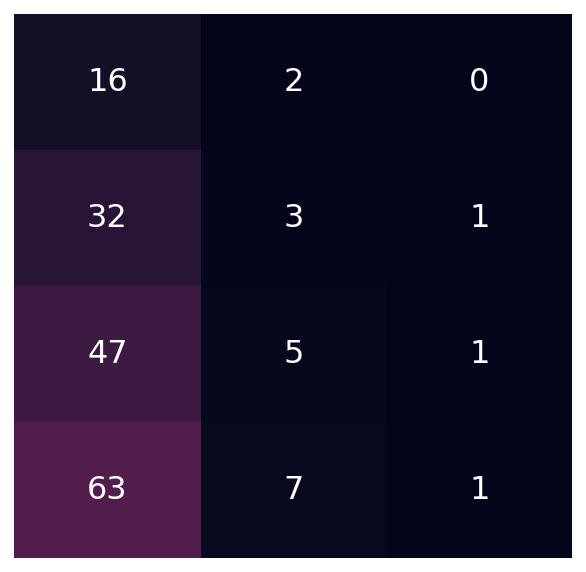

In [16]:
# Generate heatmap for the duration of the naive case for lam_MB and burden
naive_MB_burden_pivot = df_naive_duration_plate.pivot('lam_MB','mu_P','n_dilutions')
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(naive_MB_burden_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
# sns.heatmap(d_MBMD_90_pivot,ax=ax,vmin=0,vmax=100,annot=True,
#             annot_kws={'size':16})
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/naive_duration_heatmap.pdf',transparent=True)

/Users/rorywilliams/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


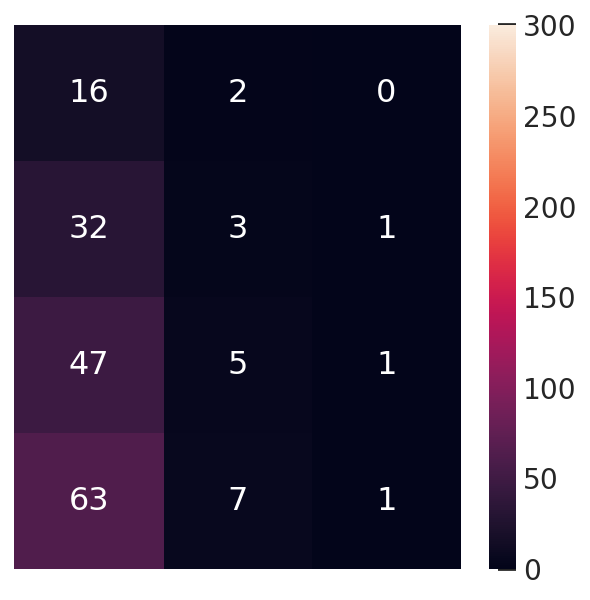

In [17]:
# Generate heatmap for the duration of the naive case for lam_MB and burden
naive_MB_burden_pivot = df_naive_duration_plate.pivot('lam_MB','mu_P','n_dilutions')
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(naive_MB_burden_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=True,annot=True,
            fmt='.0f',annot_kws={'size':16})
# sns.heatmap(d_MBMD_90_pivot,ax=ax,vmin=0,vmax=100,annot=True,
#             annot_kws={'size':16})f
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/naive_duration_heatmap_colorbar.pdf',transparent=True)

In [18]:
# Generate pivot tables with log2 of production normalized to the equivalent naive case
d_MBMD_90_ = df_MAP_params_d_plate.loc[df_MAP_params_d_plate['mu_P']==mu_Ps[0],:]
d_MBMD_50_ = df_MAP_params_d_plate.loc[df_MAP_params_d_plate['mu_P']==mu_Ps[1],:]
d_MBMD_10_ = df_MAP_params_d_plate.loc[df_MAP_params_d_plate['mu_P']==mu_Ps[2],:]
d_MBMD_90_pivot = d_MBMD_90_.pivot('lam_MB','lam_MD','n_dilutions')
d_MBMD_50_pivot = d_MBMD_50_.pivot('lam_MB','lam_MD','n_dilutions')
d_MBMD_10_pivot = d_MBMD_10_.pivot('lam_MB','lam_MD','n_dilutions')

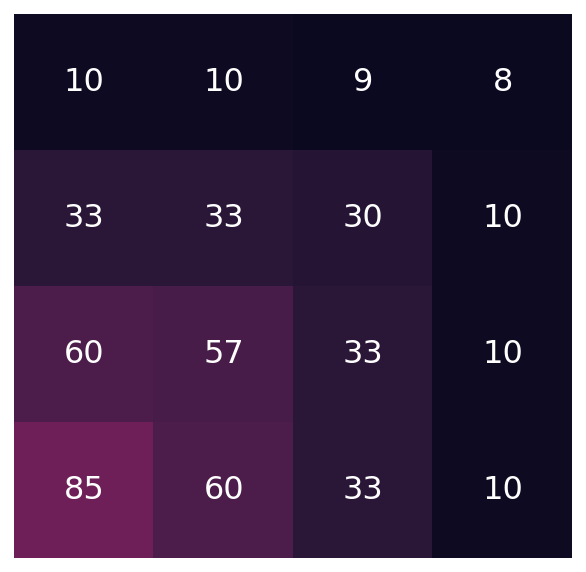

In [19]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(d_MBMD_90_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/diff_90_duration_heatmap.pdf',transparent=True)

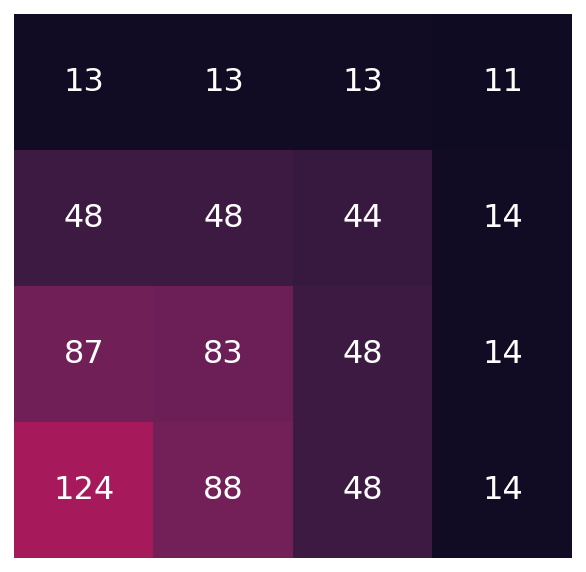

In [20]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(d_MBMD_50_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/diff_50_duration_heatmap.pdf',transparent=True)

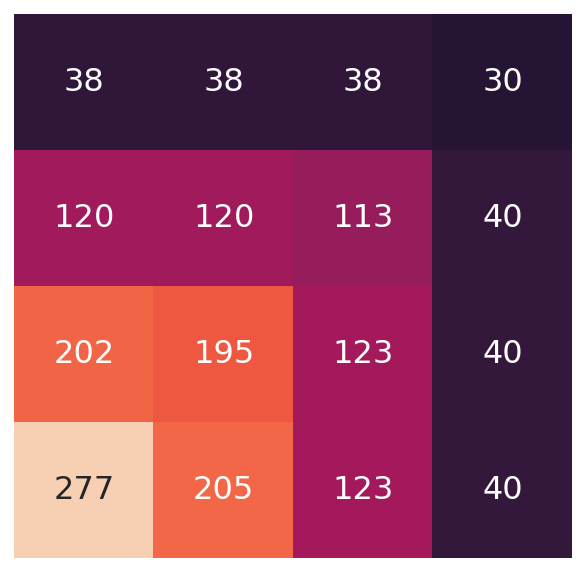

In [21]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(d_MBMD_10_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
# sns.heatmap(d_MBMD_90_pivot,ax=ax,vmin=0,vmax=100,annot=True,
#             annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/diff_10_duration_heatmap.pdf',transparent=True)

In [22]:
print(lam_MSs)
print(mu_Ps)

[0.e+00 1.e-12 1.e-09 1.e-06 1.e-03]
[0.15 0.75 1.35]


In [23]:
# Generate pivot tables for termianl differentiation for the case of 4 divisions
ds_MBMD_0MS_90_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[0]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[0]),:]
ds_MBMD_1e12MS_90_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[0]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[1]),:]
ds_MBMD_1e9MS_90_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[0]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[2]),:]
ds_MBMD_1e6MS_90_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[0]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[3]),:]
ds_MBMD_1e3MS_90_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[0]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[4]),:]

ds_MBMD_0MS_90_pivot = ds_MBMD_0MS_90_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e12MS_90_pivot = ds_MBMD_1e12MS_90_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e9MS_90_pivot = ds_MBMD_1e9MS_90_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e6MS_90_pivot = ds_MBMD_1e6MS_90_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e3MS_90_pivot = ds_MBMD_1e3MS_90_.pivot('lam_MB','lam_MD','n_dilutions')

ds_MBMD_0MS_50_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[1]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[0]),:]
ds_MBMD_1e12MS_50_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[1]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[1]),:]
ds_MBMD_1e9MS_50_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[1]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[2]),:]
ds_MBMD_1e6MS_50_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[1]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[3]),:]
ds_MBMD_1e3MS_50_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[1]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[4]),:]

ds_MBMD_0MS_50_pivot = ds_MBMD_0MS_50_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e12MS_50_pivot = ds_MBMD_1e12MS_50_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e9MS_50_pivot = ds_MBMD_1e9MS_50_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e6MS_50_pivot = ds_MBMD_1e6MS_50_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e3MS_50_pivot = ds_MBMD_1e3MS_50_.pivot('lam_MB','lam_MD','n_dilutions')

ds_MBMD_0MS_10_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[2]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[0]),:]
ds_MBMD_1e12MS_10_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[2]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[1]),:]
ds_MBMD_1e9MS_10_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[2]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[2]),:]
ds_MBMD_1e6MS_10_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[2]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[3]),:]
ds_MBMD_1e3MS_10_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[2]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[4]),:]

ds_MBMD_0MS_10_pivot = ds_MBMD_0MS_10_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e12MS_10_pivot = ds_MBMD_1e12MS_10_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e9MS_10_pivot = ds_MBMD_1e9MS_10_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e6MS_10_pivot = ds_MBMD_1e6MS_10_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e3MS_10_pivot = ds_MBMD_1e3MS_10_.pivot('lam_MB','lam_MD','n_dilutions')

Generate heatmaps for terminal differentiation for the case of 4 divisions

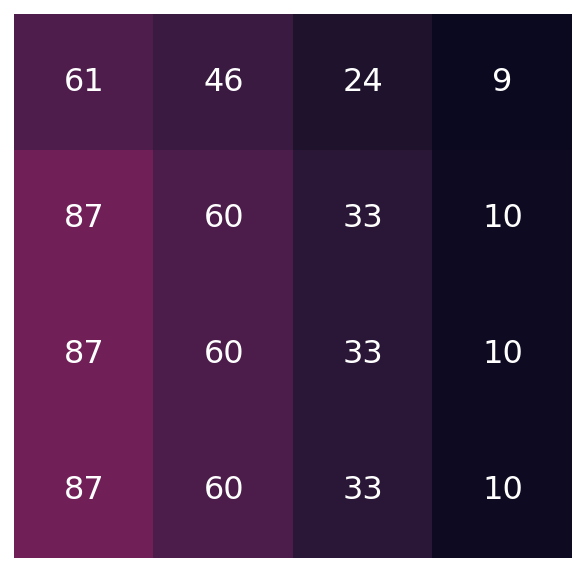

In [24]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_0MS_90_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_0MS_90_4div_duration_heatmap.pdf',transparent=True)

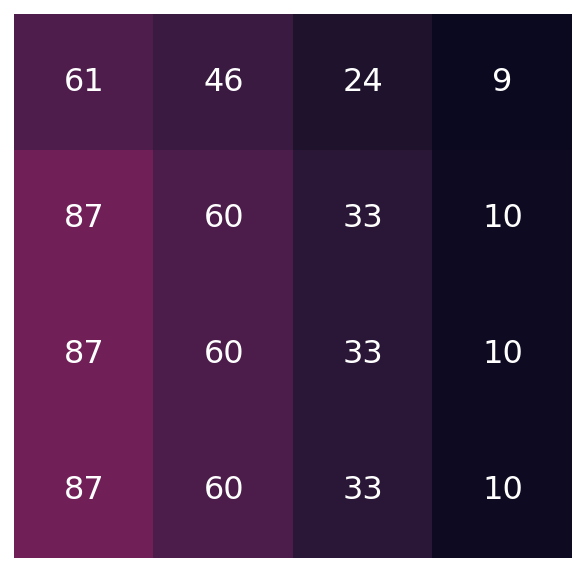

In [25]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e12MS_90_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_1e12MS_90_4div_duration_heatmap.pdf',transparent=True)

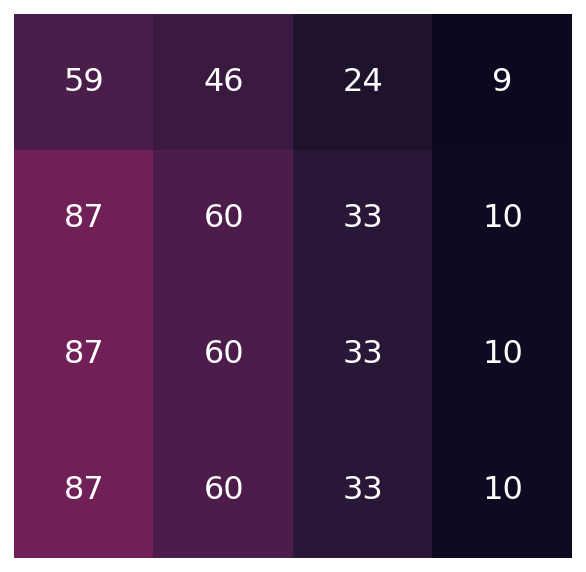

In [26]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e9MS_90_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_1e9MS_90_4div_duration_heatmap.pdf',transparent=True)

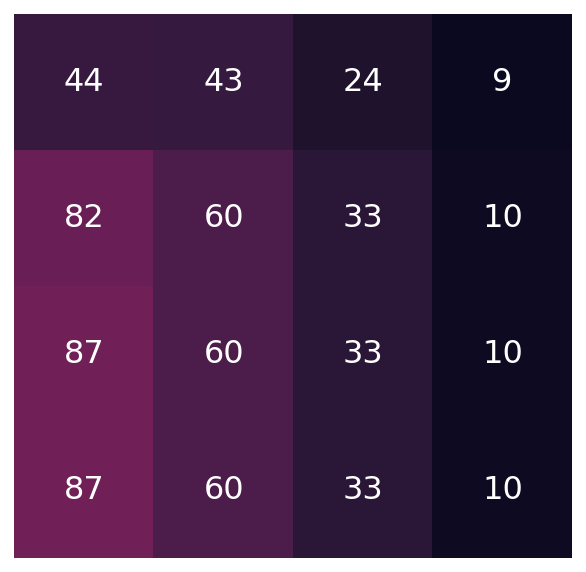

In [27]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e6MS_90_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_1e6MS_90_4div_duration_heatmap.pdf',transparent=True)

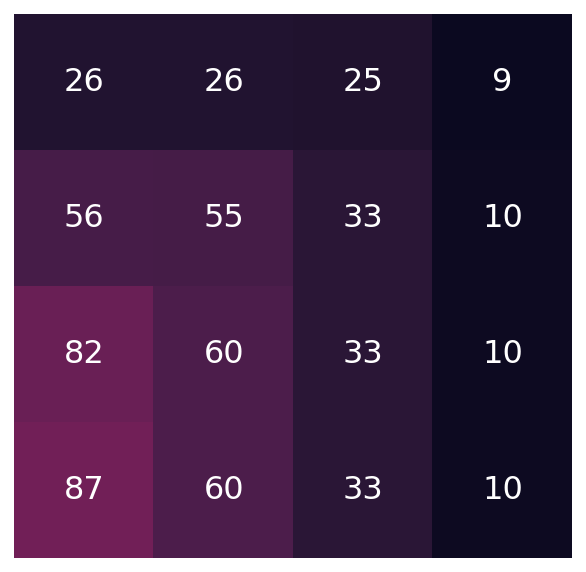

In [28]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e3MS_90_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_1e3MS_90_4div_duration_heatmap.pdf',transparent=True)

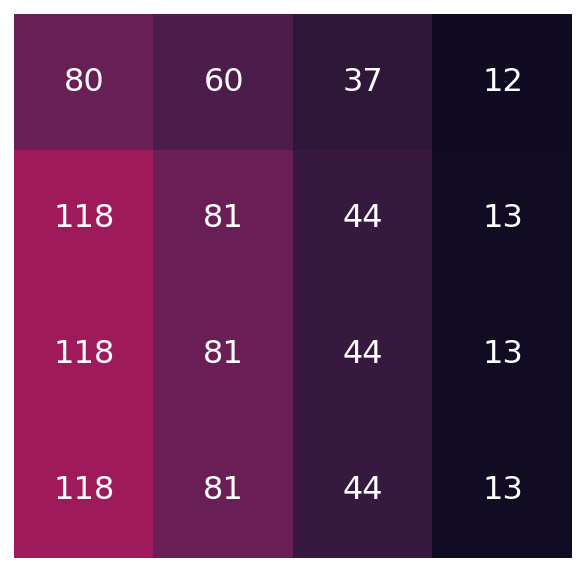

In [29]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_0MS_50_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_0MS_50_4div_duration_heatmap.pdf',transparent=True)

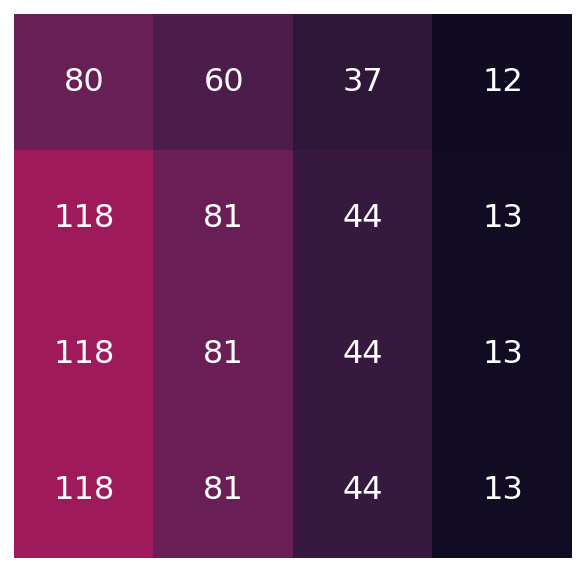

In [30]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e12MS_50_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_1e12MS_50_4div_duration_heatmap.pdf',transparent=True)

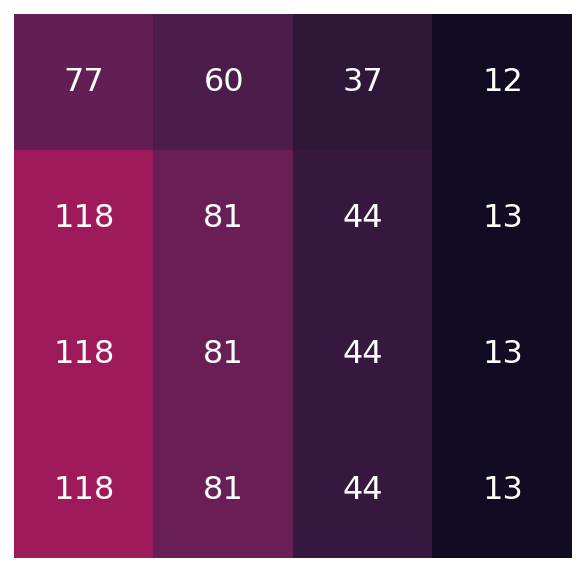

In [31]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e9MS_50_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_1e9MS_50_4div_duration_heatmap.pdf',transparent=True)

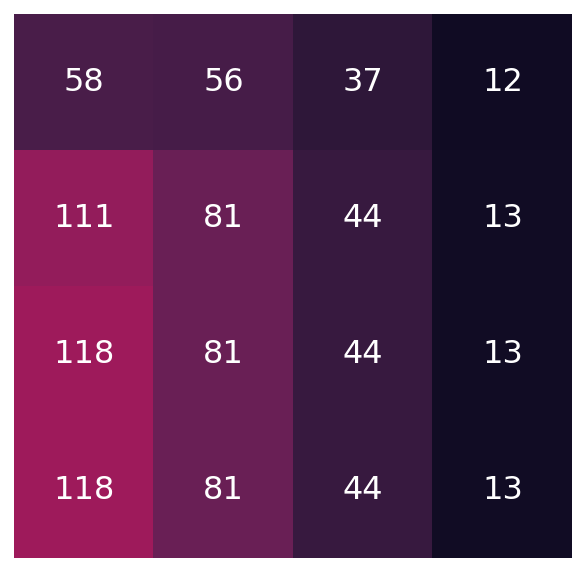

In [32]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e6MS_50_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_1e6MS_50_4div_duration_heatmap.pdf',transparent=True)

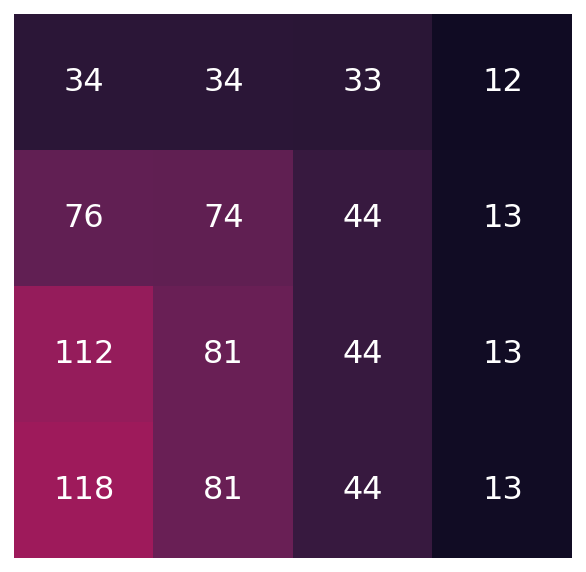

In [33]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e3MS_50_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_1e3MS_50_4div_duration_heatmap.pdf',transparent=True)

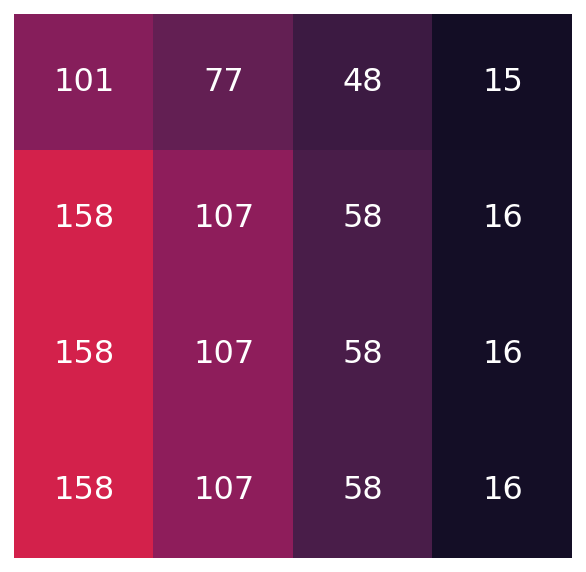

In [34]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_0MS_10_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_0MS_10_4div_duration_heatmap.pdf',transparent=True)

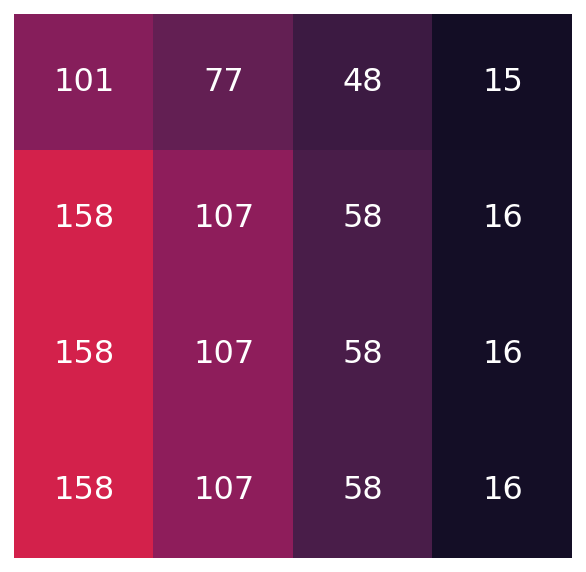

In [35]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e12MS_10_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_1e12MS_10_4div_duration_heatmap.pdf',transparent=True)

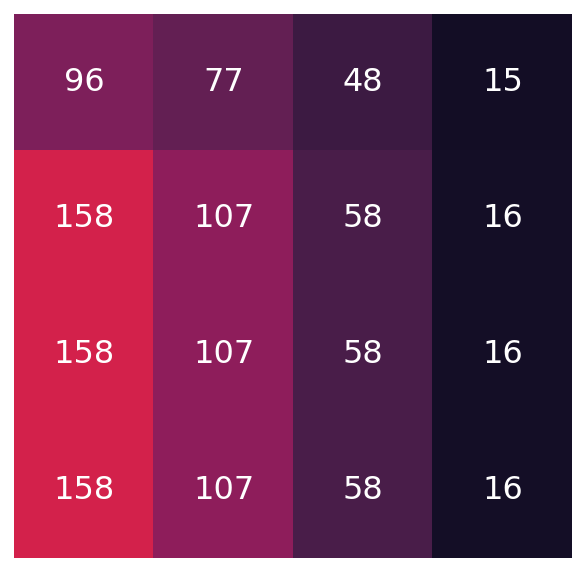

In [36]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e9MS_10_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_1e9MS_10_4div_duration_heatmap.pdf',transparent=True)

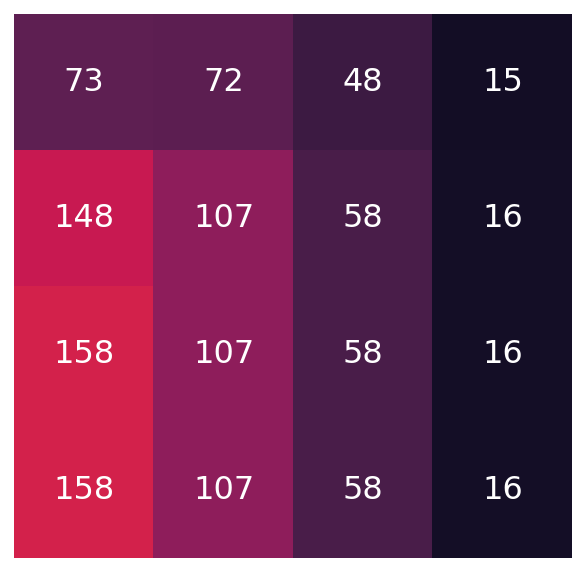

In [37]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e6MS_10_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_1e6MS_10_4div_duration_heatmap.pdf',transparent=True)

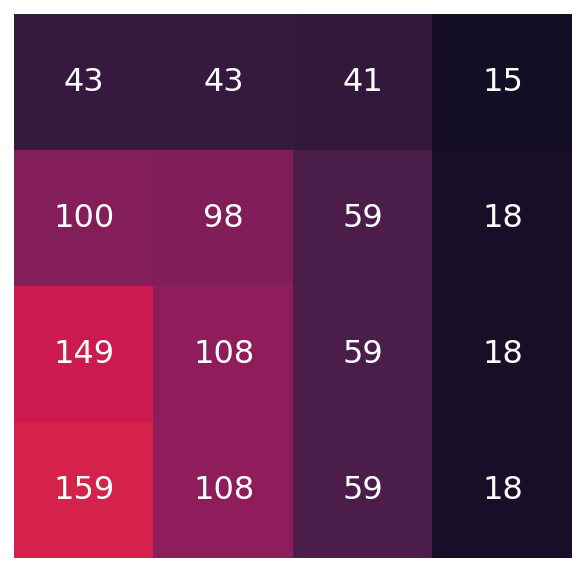

In [38]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e3MS_10_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/4_divisions/ds_1e3MS_10_4div_duration_heatmap.pdf',transparent=True)

In [39]:
## Generate pivot tables for termianl differentiation for the case of 8 divisions
ds_MBMD_0MS_90_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[0]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[0]),:]
ds_MBMD_1e12MS_90_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[0]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[1]),:]
ds_MBMD_1e9MS_90_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[0]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[2]),:]
ds_MBMD_1e6MS_90_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[0]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[3]),:]
ds_MBMD_1e3MS_90_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[0]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[4]),:]

ds_MBMD_0MS_90_pivot = ds_MBMD_0MS_90_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e12MS_90_pivot = ds_MBMD_1e12MS_90_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e9MS_90_pivot = ds_MBMD_1e9MS_90_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e6MS_90_pivot = ds_MBMD_1e6MS_90_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e3MS_90_pivot = ds_MBMD_1e3MS_90_.pivot('lam_MB','lam_MD','n_dilutions')

ds_MBMD_0MS_50_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[1]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[0]),:]
ds_MBMD_1e12MS_50_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[1]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[1]),:]
ds_MBMD_1e9MS_50_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[1]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[2]),:]
ds_MBMD_1e6MS_50_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[1]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[3]),:]
ds_MBMD_1e3MS_50_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[1]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[4]),:]

ds_MBMD_0MS_50_pivot = ds_MBMD_0MS_50_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e12MS_50_pivot = ds_MBMD_1e12MS_50_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e9MS_50_pivot = ds_MBMD_1e9MS_50_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e6MS_50_pivot = ds_MBMD_1e6MS_50_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e3MS_50_pivot = ds_MBMD_1e3MS_50_.pivot('lam_MB','lam_MD','n_dilutions')

ds_MBMD_0MS_10_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[2]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[0]),:]
ds_MBMD_1e12MS_10_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[2]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[1]),:]
ds_MBMD_1e9MS_10_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[2]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[2]),:]
ds_MBMD_1e6MS_10_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[2]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[3]),:]
ds_MBMD_1e3MS_10_ = df_MAP_params_ds_plate_4div.loc[(df_MAP_params_ds_plate_4div.mu_DPs==mu_Ps[2]) &\
                                               (df_MAP_params_ds_plate_4div.lam_MS==lam_MSs[4]),:]

ds_MBMD_0MS_10_pivot = ds_MBMD_0MS_10_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e12MS_10_pivot = ds_MBMD_1e12MS_10_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e9MS_10_pivot = ds_MBMD_1e9MS_10_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e6MS_10_pivot = ds_MBMD_1e6MS_10_.pivot('lam_MB','lam_MD','n_dilutions')
ds_MBMD_1e3MS_10_pivot = ds_MBMD_1e3MS_10_.pivot('lam_MB','lam_MD','n_dilutions')

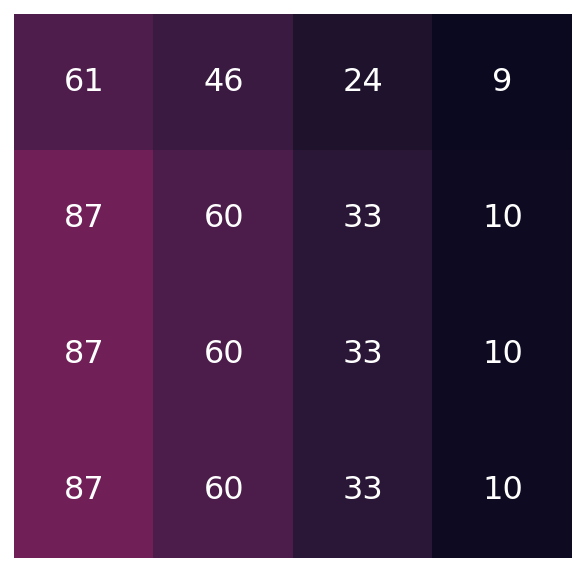

In [40]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_0MS_90_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_0MS_90_8div_duration_heatmap.pdf',transparent=True)

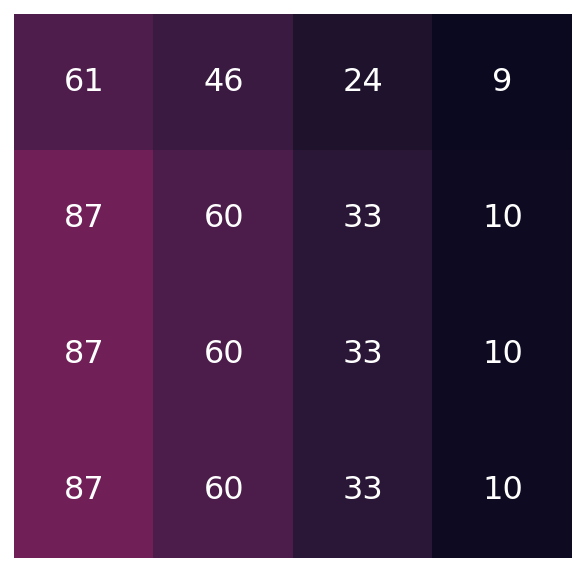

In [41]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e12MS_90_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_1e12MS_90_8div_duration_heatmap.pdf',transparent=True)

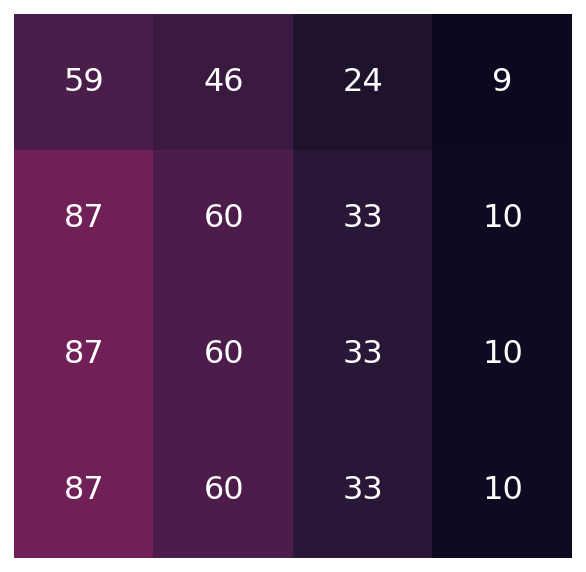

In [42]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e9MS_90_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_1e9MS_90_8div_duration_heatmap.pdf',transparent=True)

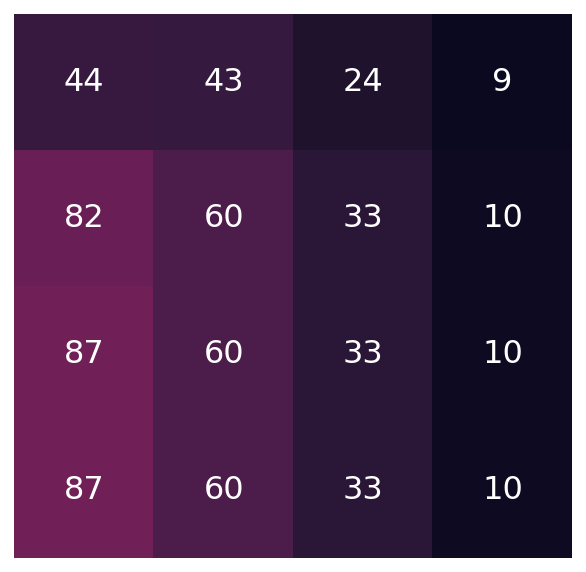

In [43]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e6MS_90_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_1e6MS_90_8div_duration_heatmap.pdf',transparent=True)

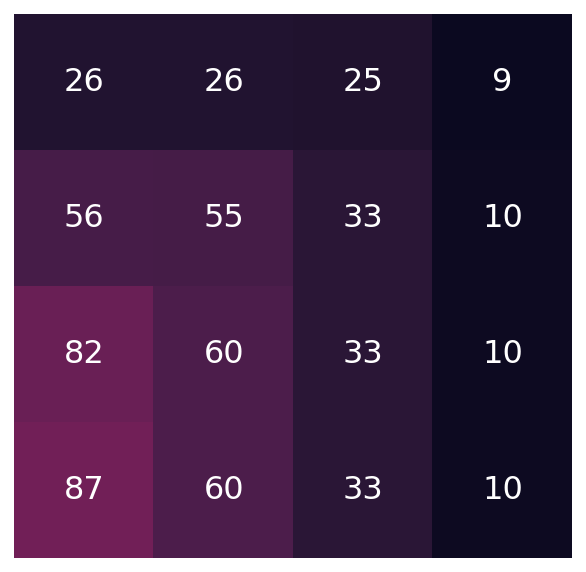

In [44]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e3MS_90_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_1e3MS_90_8div_duration_heatmap.pdf',transparent=True)

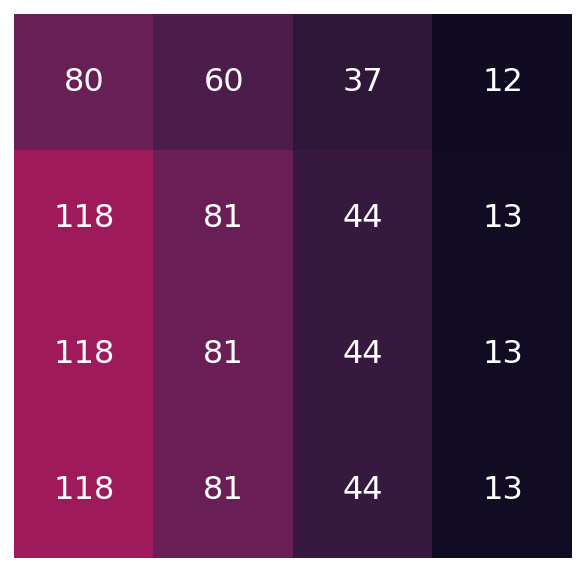

In [45]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_0MS_50_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_0MS_50_8div_duration_heatmap.pdf',transparent=True)

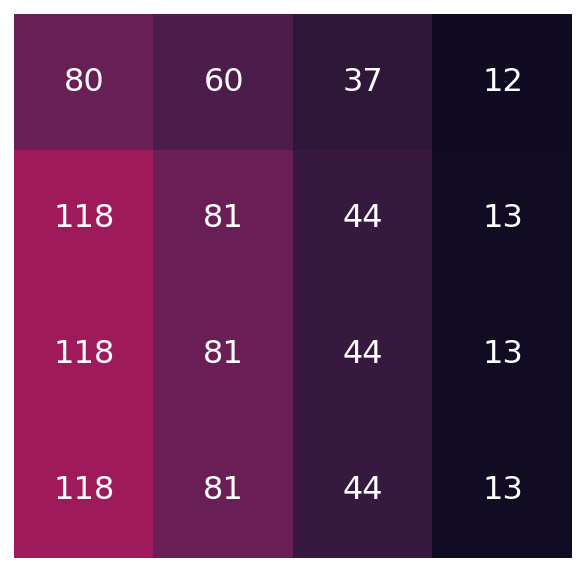

In [46]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e12MS_50_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_1e12MS_50_8div_duration_heatmap.pdf',transparent=True)

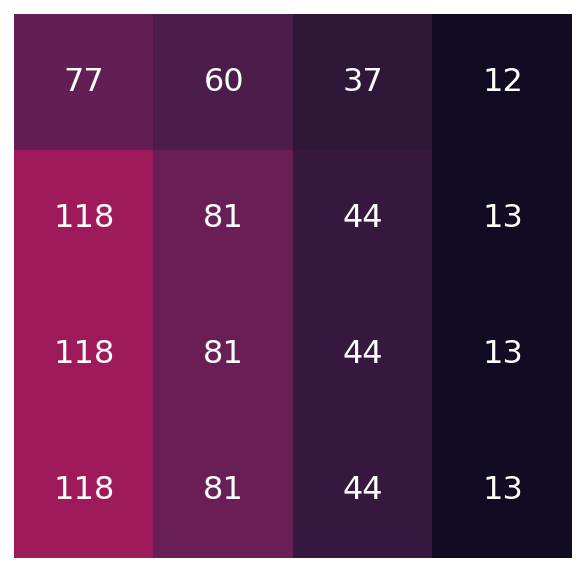

In [47]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e9MS_50_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_1e9MS_50_8div_duration_heatmap.pdf',transparent=True)

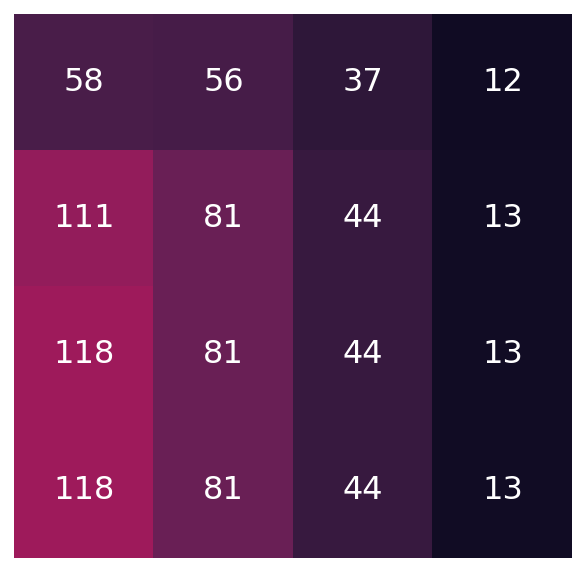

In [48]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e6MS_50_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_1e6MS_50_8div_duration_heatmap.pdf',transparent=True)

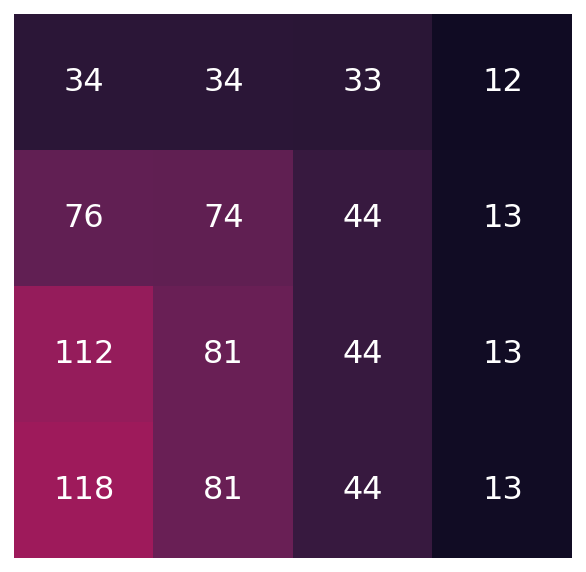

In [49]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e3MS_50_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_1e3MS_50_8div_duration_heatmap.pdf',transparent=True)

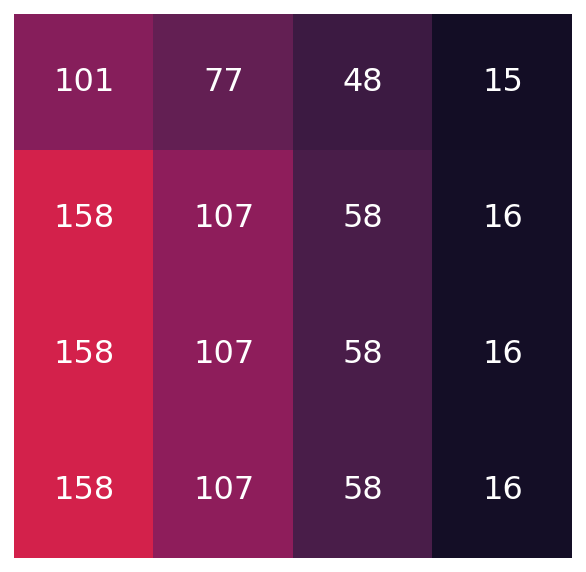

In [50]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_0MS_10_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_0MS_10_8div_duration_heatmap.pdf',transparent=True)

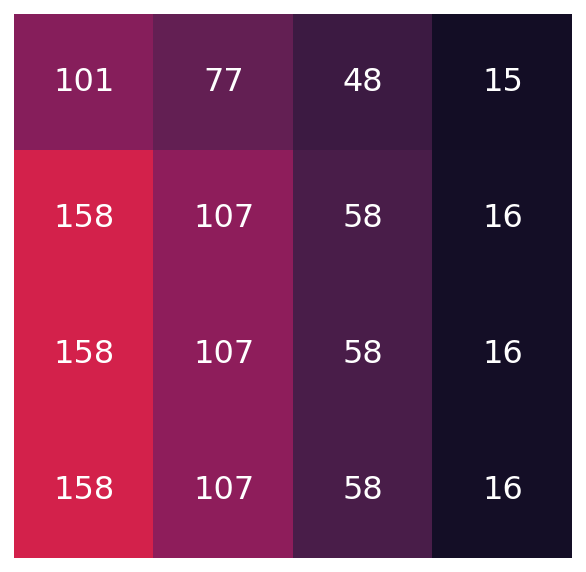

In [51]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e12MS_10_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_1e12MS_10_8div_duration_heatmap.pdf',transparent=True)

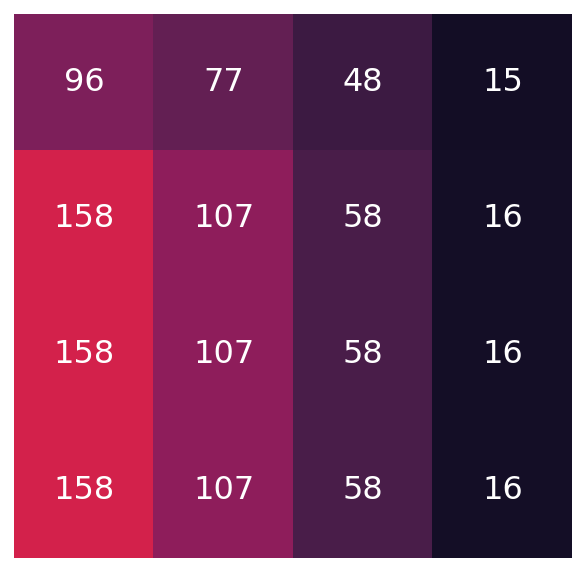

In [52]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e9MS_10_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_1e9MS_10_8div_duration_heatmap.pdf',transparent=True)

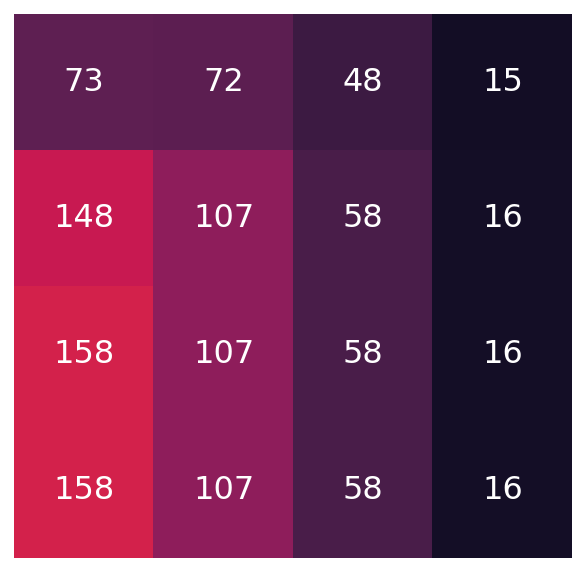

In [53]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e6MS_10_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_1e6MS_10_8div_duration_heatmap.pdf',transparent=True)

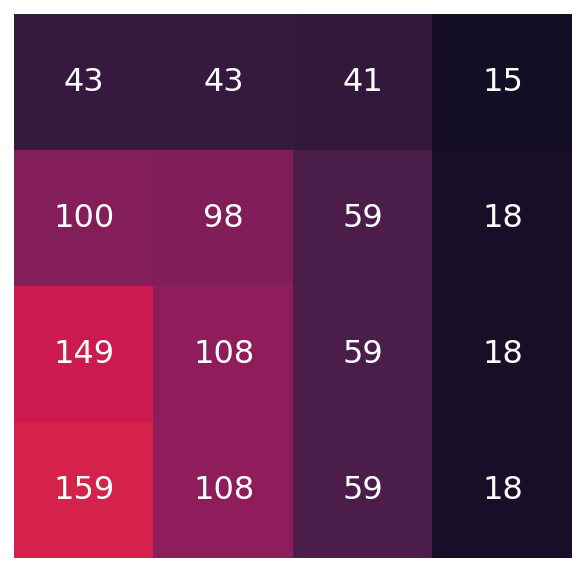

In [54]:
fig,ax=plt.subplots(figsize=(5,5))
sns.heatmap(ds_MBMD_1e3MS_10_pivot,ax=ax,vmin=0,vmax=300,xticklabels=False,yticklabels=False,cbar=False,annot=True,
            fmt='.0f',annot_kws={'size':16})
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('./optimization_heatmaps/duration/8_divisions/ds_1e3MS_10_8div_duration_heatmap.pdf',transparent=True)

Heatmaps are then manually arranged into figures.